In [39]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
import os

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Activation

def self_attention(x, filters):
    input_shape = tf.shape(x)
    height, width = input_shape[1], input_shape[2]

    query = Conv2D(filters, 1)(x)
    query = tf.reshape(query, [-1, height * width, filters])

    key = Conv2D(filters, 1)(x)
    key = tf.reshape(key, [-1, height * width, filters])

    value = Conv2D(filters, 1)(x)
    value = tf.reshape(value, [-1, height * width, filters])

    attention = tf.keras.layers.Attention()([query, key, value])

    attention = tf.reshape(attention, [-1, height, width, filters])
    return attention

def sidnet_with_attention():
    inputs = tf.keras.Input(shape=(108, 160, 3), name='InputLayer')
    conv1 = Conv2D(32, 3, activation='relu', padding='same', name='FirstConv')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', strides=2, name='SecondConv')(conv1)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', strides=2, name='ThirdConv')(conv2)

    attention = self_attention(conv3, 256)

    deconv1 = Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2, name='FirstDeConv')(attention)
    skip1 = Concatenate()([deconv1, conv2])
    deconv2 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2, name='SecondDeConv')(skip1)
    skip2 = Concatenate()([deconv2, conv1])
    deconv2 = Conv2DTranspose(32, 3, activation='relu', padding='same', strides=2, name='SecondDeConv')(skip2)
    output = Conv2D(3, 3, activation='sigmoid', padding='same', name='OutputLayer')(deconv2)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='DHaRT')
    return model

model = sidnet_with_attention()


def self_attention(x, filters):
    # Get the shape of the input tensor
    input_shape = tf.shape(x)
    height, width = input_shape[1], input_shape[2]
    print(height,width)

    # Reshape query, key, and value tensors
    query = Conv2D(filters // 8, 1)(x)
    query = tf.reshape(query, [-1, height * width, filters // 8])

    key = Conv2D(filters // 8, 1)(x)
    key = tf.reshape(key, [-1, height * width, filters // 8])

    value = Conv2D(filters, 1)(x)
    value = tf.reshape(value, [-1, height * width,  filters // 8],name='reshaping_here')

    # Apply attention mechanism
    attention = tf.keras.layers.Attention(name='Attention_layer')([query, key, value])

    # Reshape attention tensor
    attention = tf.reshape(attention, [-1, height, width, filters])
    return attention

def sidnet_with_attention():
    # Encoder
    inputs = tf.keras.Input(shape=(460, 620,3),name='InputLayer')
    conv1 = Conv2D(64, 3, activation='relu', padding='same',name='FirstConv')(inputs)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', strides=2,name='SecondConv')(conv1)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', strides=2,name='ThirdConv')(conv2)

    # Self-attention applied to the encoder output
    attention = self_attention(conv3, 256)

    # Decoder
    deconv1 = Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2,name='FirstDeConv')(attention)
    skip1 = Concatenate(name='FirstSkip')([deconv1, conv2])
    deconv2 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2,name='SecondDeConv')(skip1)
    skip2 = Concatenate(name='SecondSkip')([deconv2, conv1])
    output = Conv2D(3, 3, activation='sigmoid', padding='same',name='OutputLayer')(skip2)

    model = tf.keras.Model(inputs=inputs, outputs=output,name='DHaRT')
    return model

# Create an instance of the SIDNet model with attention
model = sidnet_with_attention()

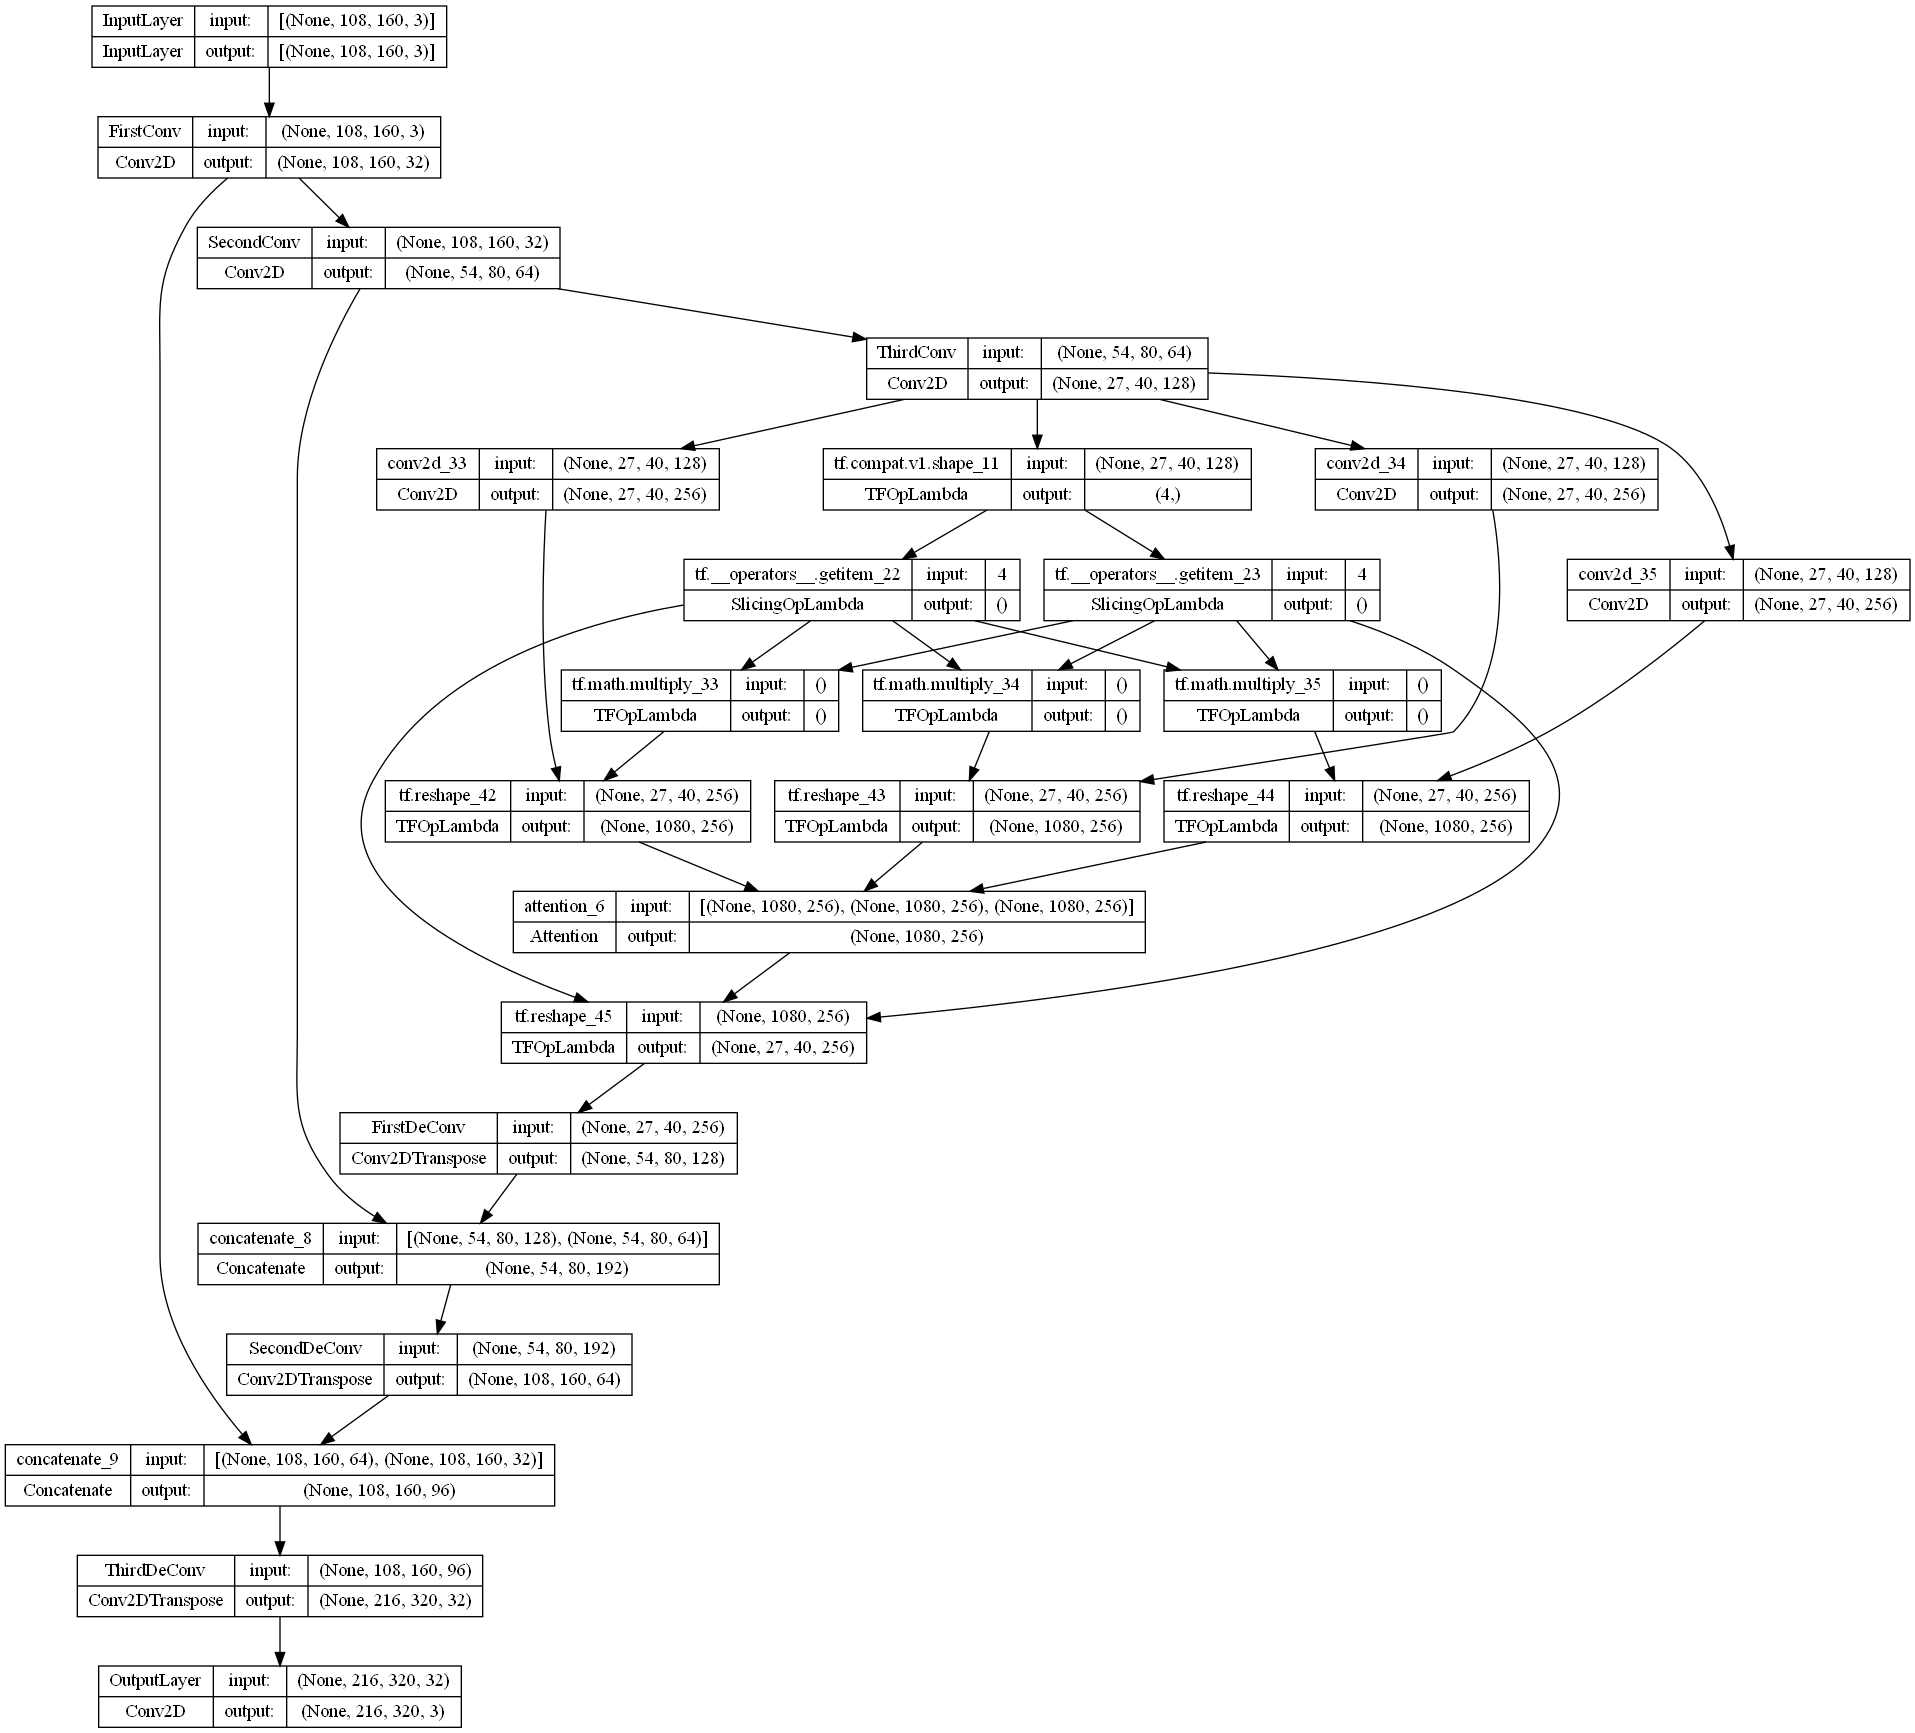

In [43]:
keras.utils.plot_model(model,show_shapes=True)

In [44]:
model.summary()

Model: "DHaRT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 108, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 FirstConv (Conv2D)             (None, 108, 160, 32  896         ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 SecondConv (Conv2D)            (None, 54, 80, 64)   18496       ['FirstConv[0][0]']              
                                                                                              

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [46]:
from keras.preprocessing.image import ImageDataGenerator
path=os.getcwd()

# Set the paths to the directories
hazy_dir = os.path.join(path,'indoor','hazy')
clear_dir = os.path.join(path,'indoor','clear')

# Calculate the number of steps per epoch
batch_size = 32
hazy_images = len(os.listdir(hazy_dir))
clear_images = len(os.listdir(clear_dir))
steps_per_epoch = clear_images // batch_size

# Create the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Load the images and create the dataset
train_generator = datagen.flow_from_directory(directory=hazy_dir,
                                              target_size=(620, 460),
                                              batch_size=batch_size,
                                              class_mode=None,
                                              shuffle=False
                                              )

train_labels_generator = datagen.flow_from_directory(directory=clear_dir,
                                                     target_size=(620, 460),
                                                     batch_size=batch_size,
                                                     class_mode=None,
                                                     shuffle=False
                                                     )

# Combine the hazy and clear images into a dataset
train_dataset = zip(train_generator, train_labels_generator)


Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


In [38]:
model.fit(train_dataset,epochs=2)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'DHaRT/attention_3/MatMul' defined at (most recent call last):
    File "c:\Users\user\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\user\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\user\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\user\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\user\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\user\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\user\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_5692\2197217471.py", line 1, in <module>
      model.fit(train_dataset,epochs=2)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\layers\attention\base_dense_attention.py", line 165, in call
      scores = self._calculate_scores(query=q, key=k)
    File "c:\Users\user\anaconda3\lib\site-packages\keras\layers\attention\attention.py", line 181, in _calculate_scores
      scores = tf.matmul(query, key, transpose_b=True)
Node: 'DHaRT/attention_3/MatMul'
OOM when allocating tensor with shape[32,17825,17825] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node DHaRT/attention_3/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12918]